In [180]:
import arcgis
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.validation import make_valid
from shapely import from_wkt

In [4]:
# Download all traffic counts from Open Data
service_url = "https://services3.arcgis.com/dty2kHktVXHrqO8i/arcgis/rest/services/Traffic_Counts_view/FeatureServer/0"
traffic_featureservice = arcgis.features.FeatureLayer(service_url)
all_counts = traffic_featureservice.query()
sdf = all_counts.sdf
all_counts_gdf = gpd.GeoDataFrame(sdf, geometry=sdf.SHAPE)

In [188]:
# Download all neighborhood boundaries from Open Data
service_url = "https://www.clevelandgis.org/arcgis/rest/services/ReferenceLayers/SPA/FeatureServer/0"
neighborhoods_featureservice = arcgis.features.FeatureLayer(service_url)
neighborhoods_query = neighborhoods_featureservice.query()

# Esri's arcgis package has a bug that ruins multipolygons, the city neighborhood layer has dirty zones that are exclaves.
neigh_df = neighborhoods_query.df
shapes = list(map(lambda geom: geom.WKT if geom else None, neigh_df['SHAPE']))
new_shapes = [make_valid(from_wkt(shape)) for shape in shapes]
neigh_df['wkt'] = new_shapes
neighborhoods_gdf = gpd.GeoDataFrame(neigh_df, geometry='wkt')

In [6]:
# Download all crash data from Open Data Cleveland City Planning
crashes_url = "https://services3.arcgis.com/dty2kHktVXHrqO8i/arcgis/rest/services/Cleveland_Traffic_Crashes_view/FeatureServer/62"
crashes_featureservice = arcgis.features.FeatureLayer(crashes_url)
crashes_query = crashes_featureservice.query()
sdf = crashes_query.sdf
crashes_gdf = gpd.GeoDataFrame(sdf, geometry=sdf.SHAPE)

In [189]:
# Spatial join traffic counts to neighborhood. They gain a neighborhood column based on spatial intersection.
counts_sj = all_counts_gdf.sjoin(neighborhoods_gdf[['SPANM','wkt']], how='left')
# Count # of counts by neighborhood, store for later
counts_agg = counts_sj.groupby("SPANM").size()

In [195]:
# Spatial join crashes to neighborhood, like above
crashes_sj = crashes_gdf.sjoin(neighborhoods_gdf[['SPANM','wkt']], how='left')
# Aggregate crashes
crash_agg = (crashes_sj
    # Filter for crashes not occuring on interstates irrelevant to local context
    [crashes_sj['FUNCTIONAL_CLASS_CD'] != 1]
    # Count by crash severity type by neighborhood
    .pivot_table(index="SPANM", columns=['CRASH_SEVERITY_CD'], values=['OBJECTID'],aggfunc='count')\
    # Flatten column index
    .droplevel(0, axis=1)
    # Rename severity to plainer English
    .rename(columns={1.0: "Fatal",
                     2.0: "Serious",
                     3.0: "Minor Injury",
                     4.0: "Possible Injury",
                     5.0: "No Injury"})
    # Crash index weighted by severity of the crashes. For example, a fatal crash has 20x more impact on the result than a possible injury.
    # These are experimental weights and depend on what kind of analysis you want to favor: frequency of report vs. severity
    .assign(Weighted_Crash_Index = lambda x: x["Fatal"] * 20
            + x['Serious'] *10
            + x["Minor Injury"] *3
            + x["Possible Injury"] *1
            + x['No Injury'] * 0.2)
    # Scale crash severity/volume to max 100
    .assign(Weighted_Crash_Index_Scaled= lambda x:
            100 * (x["Weighted_Crash_Index"] - x["Weighted_Crash_Index"].min()) /
            (x["Weighted_Crash_Index"].max()- x["Weighted_Crash_Index"].min())
            )
)

In [196]:
# Create ratio to assess whether dangerous areas get proportional counts
# Number of traffic counts performed DIVIDED BY Weighted (by severity) crashes
ratio_name = 'Traffic Counts to Crashes Ratio'

# Merge the two neighborhood-level aggregations of counts and crashes together, create final result
analytics_result = (crash_agg.merge(counts_agg.to_frame(), on='SPANM')
                    # Rename columns for readability
                    .rename(columns={0:'Traffic Counts Performed'})
                    # Create the ratio
                    .assign(**{ratio_name: lambda x: x['Traffic Counts Performed'] / x['Weighted_Crash_Index_Scaled']})
                    .reset_index()
                    .sort_values(ratio_name, ascending=False)
                    # Ranking various metrics for ease in comparing
                    .assign(**{"Crash Index Rank": lambda df: df['Weighted_Crash_Index'].rank(ascending=False)})
                    .assign(**{"Traffic Counts Rank": lambda df: df['Traffic Counts Performed'].rank(ascending=False)})
                    .assign(**{"Counts to Crash Ratio Rank": lambda df: df[ratio_name].rank(ascending=False)})
                    # Change SPANM to neighborhood
                    .rename(columns={"SPANM":"Neighborhood"})
)

## Interpreting the Traffic Counts to Crashes Ratio	

With a grain of salt, this simple metric design can be interpreted as:
* High values reflect more traffic analysis attention in proprotion to crash activity in that neighborhood.
* Low values reflect less traffic analysis attention in proportion to crash activity in that neighborhood.

## Interpreting the Rankings

* Crash Index - Rank 1 had the most crash activity compared to other neighborhoods, weighting for severity as explained
* Traffic Counts Rank - Rank 1 is neighborhood that saw the most traffic counts
* Counts to Crash Ratio - Rank 1 had the most counts per crash

In [197]:
analytics_result.sort_values("Neighborhood")

,Neighborhood,Fatal,Serious,Minor Injury,Possible Injury,No Injury,Weighted_Crash_Index,Weighted_Crash_Index_Scaled,Traffic Counts Performed,Traffic Counts to Crashes Ratio,Crash Index Rank,Traffic Counts Rank,Counts to Crash Ratio Rank
0,Bellaire-Puritas,2,54,332,863,2671,2973.2,30.592208,5,0.16344,18.0,31.0,31.0
1,Broadway-Slavic Village,23,114,567,1244,3982,5341.4,64.192276,44,0.685441,6.0,5.0,12.0
2,Brooklyn Centre,11,74,376,642,2911,3312.2,35.401947,7,0.197729,15.0,30.0,30.0
3,Buckeye-Shaker Square,2,36,231,663,2005,2157.0,19.011946,30,1.577955,27.0,12.5,4.0
4,Buckeye-Woodhill,11,50,216,497,1429,2150.8,18.923981,13,0.686959,29.0,22.0,10.0
5,Central,20,132,646,1580,4741,6186.2,76.178315,20,0.262542,5.0,17.0,28.0
6,Clark-Fulton,8,64,342,639,2711,3007.2,31.074601,15,0.482709,16.0,20.0,20.0
7,Collinwood-Nottingham,22,131,529,1078,3724,5159.8,61.615732,10,0.162296,7.0,27.0,32.0
8,Cudell,6,60,265,575,2113,2512.6,24.057206,30,1.247028,23.0,12.5,6.0
9,Cuyahoga Valley,10,55,189,490,1726,2152.2,18.943844,13,0.686239,28.0,22.0,11.0


Text(0.75, 0.9, 'ODOT GCAT Crashes, 2017-2023')

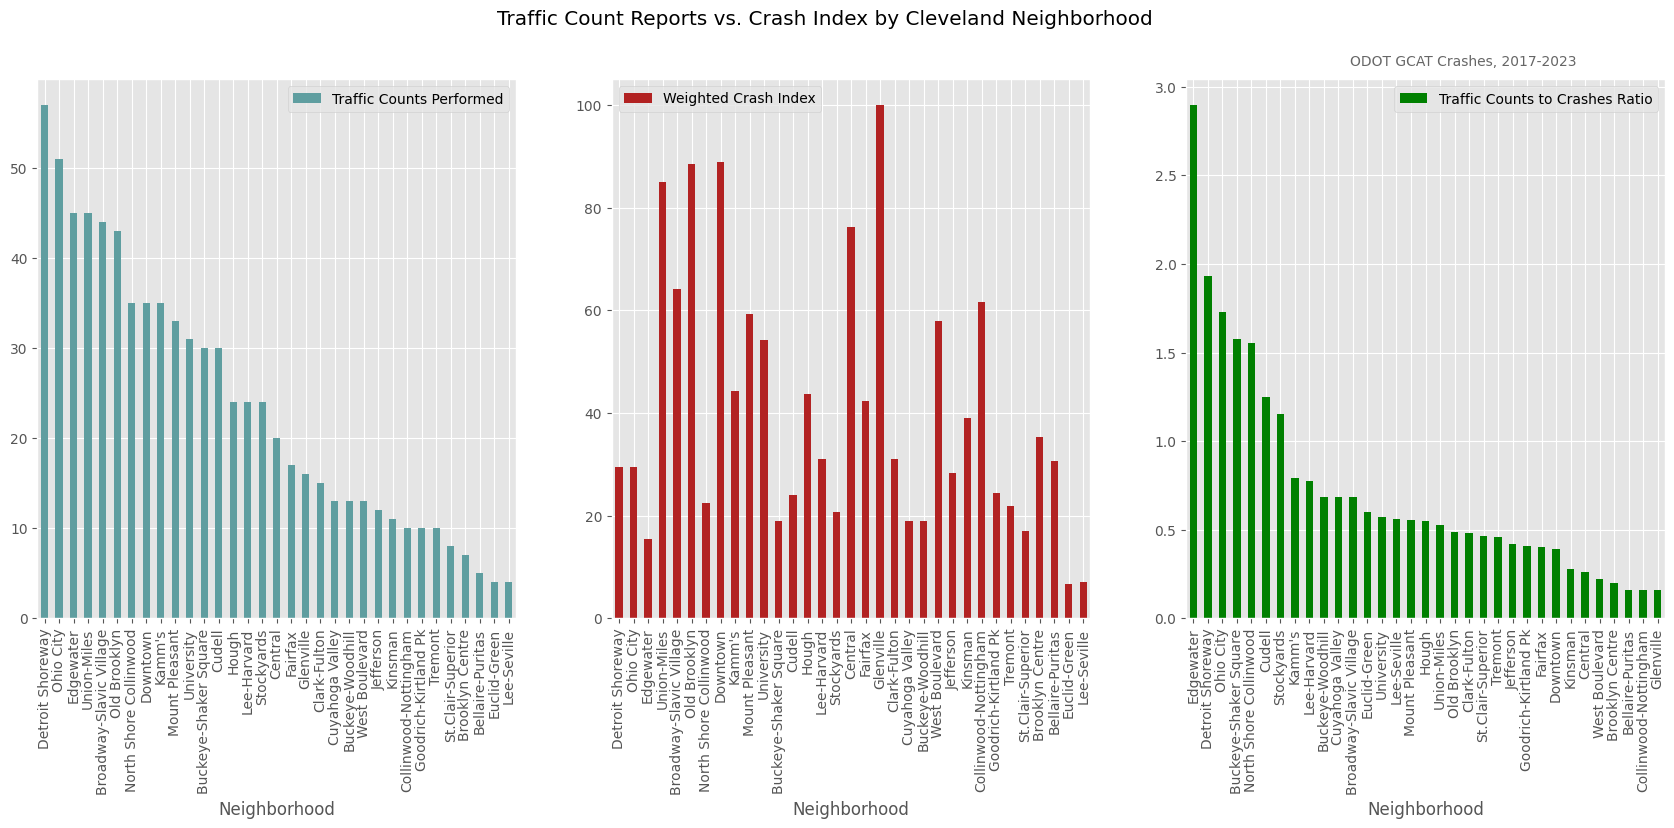

In [198]:
fig, ax = plt.subplots(1,3, figsize=(21,7))
analytics_result.sort_values("Traffic Counts Performed", ascending=False).plot.bar(ax=ax[0], x='Neighborhood', y='Traffic Counts Performed', color='cadetblue')
analytics_result.sort_values("Traffic Counts Performed", ascending=False).plot.bar(ax=ax[1], x='Neighborhood', y='Weighted_Crash_Index_Scaled', color='firebrick', label="Weighted Crash Index")
analytics_result.plot.bar(ax=ax[2], x='Neighborhood', y=ratio_name, color='g')
fig.suptitle('Traffic Count Reports vs. Crash Index by Cleveland Neighborhood', size='x-large')
# Add a caption
caption = 'ODOT GCAT Crashes, 2017-2023'
plt.figtext(0.75, 0.9, caption, wrap=True, horizontalalignment='left', fontsize=10, color="0.4")

Text(0, 0.5, 'Traffic Counts Performed')

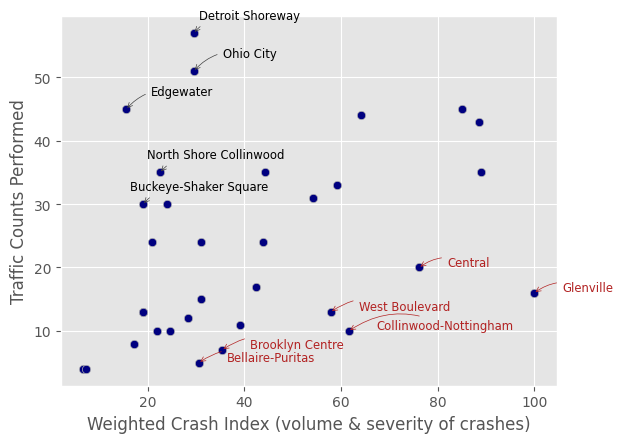

In [206]:
x_col = "Weighted_Crash_Index_Scaled"
y_col = "Traffic Counts Performed"

plt.style.use('ggplot')
plt.scatter(data=analytics_result, x=x_col, y=y_col, color="navy", edgecolors='0.7')
top_5 = analytics_result.nlargest(5, ratio_name)
for i in top_5.index:
    plt.annotate(f"{analytics_result['Neighborhood'][i]}",
                 xy=(analytics_result[x_col][i], analytics_result[y_col][i]), textcoords="offset points", xytext=(40, 10), ha='center', color='black', size='small',
                 arrowprops=dict(arrowstyle="->",
                            color="0.25",
                            patchB=None,
                            shrinkB=1,
                            connectionstyle="arc3,rad=0.3",
                            ))
    
bot_5 = analytics_result.nsmallest(6, ratio_name)
for i in bot_5.index:
    plt.annotate(f"{analytics_result['Neighborhood'][i]}",
                 xy=(analytics_result[x_col][i], analytics_result[y_col][i]), textcoords="offset points", xytext=(20, 1), ha='left', color='firebrick', size='small',
                 arrowprops=dict(arrowstyle="->",
                            color="firebrick",
                            patchB=None,
                            shrinkB=1,
                            connectionstyle="arc3,rad=0.3",
                            ))
plt.xlabel('Weighted Crash Index (volume & severity of crashes)')
plt.ylabel(y_col)

## Key Takeaways
* Edgewater saw the most traffic counts for the least traffic crash severity and volume.
    * 45 counts occurred here. It has the 3rd safest crash activity out of 34 neighborhoods
* Detroit Shoreway and Ohio City are noticeably studied for traffic activity often. They are the only 2 that top 50 traffic count reports.
* Glenville has the most severe/frequent crash activity in the City, but it has 1/3rd the traffic observations of crash activity peers (Slavic Village, Union Miles, Downtown)

## A Few (But Not All) Caveats
* The weighting system is subjective and can impact rankings to some extent.
* The method for spatial joining could be *misleading* for crashes that are on the borders of 2 neighborhoods.
    * e.g. Euclid Ave is both Central and Hough. In theory crashes on edges should count for both neighborhoods. In practice, the coordinates could fall slightly out of bounds and only be counted in one.
    * One remedy is to first snap crash points within 20 feet of a neighborhood boundary to that boundary line.